<a href="https://colab.research.google.com/github/serg-kas/Seams-segm/blob/master/Model_Unet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Unet

In [1]:
!git clone https://github.com/serg-kas/Seams-segm
%cd Seams-segm
!ls

Cloning into 'Seams-segm'...
remote: Enumerating objects: 474, done.
remote: Counting objects: 100% (93/93), done.
remote: Compressing objects: 100% (91/91), done.
remote: Total 474 (delta 2), reused 93 (delta 2), pack-reused 381
Receiving objects: 100% (474/474), 120.50 MiB | 50.72 MiB/s, done.
Resolving deltas: 100% (57/57), done.
/content/Seams-segm
imgs  masks  prep_data.py  README.md  utils.py


In [2]:
# Импорт библиотек
import numpy as np
import math
import cv2 as cv
import random
import os
import time
#
import utils as u 
#
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model 
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.layers import Input, Conv2DTranspose, concatenate, Activation, MaxPooling2D, Conv2D
from tensorflow.keras.layers import Reshape, GlobalAveragePooling2D, UpSampling2D, AveragePooling2D
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from keras.callbacks import ReduceLROnPlateau, EarlyStopping 
from tensorflow.keras.utils import Sequence
from tensorflow.keras.models import load_model, save_model
from tensorflow.keras.applications.vgg16 import VGG16
#
import albumentations as A
#
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# Пути к данным
images_path = "/content/Seams-segm/imgs"
anns_path = "/content/Seams-segm/masks"

In [4]:
# Создадим списки файлов с путями к ним
img_names= [ os.path.join(images_path, file_name) for file_name in os.listdir(images_path)]
ann_names = [ os.path.join(anns_path, file_name) for file_name in os.listdir(anns_path)]

In [7]:
# Соберем информацию о классах разметки сегментации
ann_set = np.array([])
cur_time = time.time()
for file_name  in ann_names:
    ann = cv.imread(file_name,0)
    # print(ann.shape)
    curr_set = np.unique(ann)
    ann_set = np.union1d(ann_set, curr_set)
    
print("Получили классы разметки: {}".format(ann_set))
print("Время выполнения: ", round(time.time() - cur_time, 2), 'c', sep='')

Получили классы разметки: [  0. 255.]
Время выполнения: 0.82c


In [ ]:
# Функция  - генератор данных
def generate_data(batchsize):
    x_data = []
    y_data = []
    batchcount = 0
    while True:
        # Получаем случайное показание прибора
        curr_img, curr_r = u.get_random_measurement(img, L, angle_0, angle_1)
        #
        curr_img = cv.resize(curr_img, (224, 224), cv.INTER_LINEAR)
        curr_img = curr_img / 255.
        # 
        curr_r_class = int(curr_r * 60)
        curr_r_ohe = np.zeros((60),dtype = np.uint8)
        curr_r_ohe[curr_r_class] = 1

        x_data.append(curr_img)
        y_data.append(curr_r_ohe)
        batchcount += 1
        if batchcount >= batchsize:
            X = np.array(x_data, dtype='float32')
            y = np.array(y_data, dtype='float32')
            # print(X.shape, y.shape)
            yield (X, y)
            x_data = []
            y_data = []
            batchcount = 0


### CNN

In [ ]:
# Функция создания модели
def get_model(img_height, img_width):
  model = Sequential()
  #Первый сверточный слой
  model.add(Conv2D(128, (3, 3), padding='same', activation='relu', input_shape=(img_height, img_width, 3)))
  model.add(BatchNormalization())

  # Второй сверточный слой
  model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(3, 3)))
  model.add(Dropout(0.2))

  # Третий сверточный слой
  model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
  model.add(BatchNormalization())
  #model.add(Dropout(0.2))   

  # Четвертый сверточный слой
  model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(3, 3)))
  model.add(Dropout(0.2)) 

  # Пятый сверточный слой
  model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
  #model.add(Dropout(0.2))
  model.add(BatchNormalization())

  # Шестой сверточный слой
  model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2)))

  # Слой регуляризации Dropout
  model.add(Dropout(0.2))  

  # Слой преобразования двумерных данных в одномерные 
  model.add(Flatten())
  # Полносвязный слой
  model.add(Dense(1024, activation='relu'))
  model.add(Dropout(0.2))

  # Полносвязный слой
  model.add(Dense(1024, activation='relu'))  
  model.add(Dropout(0.2))

  # Выходной слой
  model.add(Dense(60, activation='softmax'))
 
  # model.compile(loss='categorical_crossentropy', optimizer=RMSprop(learning_rate=0.001), metrics=['accuracy'])
  model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

  return model


In [ ]:
    # Создаем модель
    model = get_model(img_example.shape[0], img_example.shape[1])
    # Напечатаем архитектуру
    model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 175, 511, 128)     3584      
                                                                 
 batch_normalization (BatchN  (None, 175, 511, 128)    512       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 175, 511, 128)     147584    
                                                                 
 batch_normalization_1 (Batc  (None, 175, 511, 128)    512       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 58, 170, 128)     0         
 )                                                               
                                                        

### VGG16

In [ ]:
# скачиваем модель
# base_model = VGG16(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
base_model = VGG16(include_top=True, weights='imagenet', input_shape=(224, 224, 3))

In [ ]:
x = Dense(60, activation='softmax', name='predictions')(base_model.layers[-2].output)

#Then create the corresponding model 
model = Model(inputs=base_model.input, outputs=x)
model.summary()

In [ ]:
# Замораживаем слои не подлежащие обучению
for layer in model.layers[:19]:
    layer.trainable = False

In [ ]:
# Посмотрим список слоёв
for i, layer in enumerate(model.layers):
    print(i, layer.name, layer.trainable)

In [ ]:
lr = 0.001

# opt = SGD(learning_rate=lr, momentum=0.9)
opt = SGD(learning_rate=lr, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
# model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
# model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=lr), metrics=['accuracy'])

In [ ]:
# Запускаем обучение
batch_size = 10
history = model.fit(generate_data(batch_size),steps_per_epoch= 1000/batch_size, epochs=100)

Epoch 1/100
100/100 [==============================] - 22s 186ms/step - loss: 4.3942 - accuracy: 0.0180
Epoch 2/100
100/100 [==============================] - 19s 190ms/step - loss: 4.1103 - accuracy: 0.0200
Epoch 3/100
100/100 [==============================] - 19s 188ms/step - loss: 4.1058 - accuracy: 0.0160
Epoch 4/100
100/100 [==============================] - 19s 186ms/step - loss: 4.0972 - accuracy: 0.0140
Epoch 5/100
100/100 [==============================] - 19s 186ms/step - loss: 4.0943 - accuracy: 0.0200
Epoch 6/100
100/100 [==============================] - 19s 187ms/step - loss: 4.0958 - accuracy: 0.0210
Epoch 7/100
100/100 [==============================] - 19s 188ms/step - loss: 4.0960 - accuracy: 0.0140
Epoch 8/100
100/100 [==============================] - 19s 187ms/step - loss: 4.0961 - accuracy: 0.0190
Epoch 9/100
100/100 [==============================] - 19s 187ms/step - loss: 4.0938 - accuracy: 0.0260
Epoch 10/100
100/100 [==============================] - 19s 187m

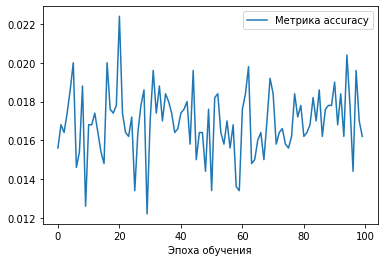

In [ ]:
# График точности обучения
plt.plot(history.history['accuracy'], label='Метрика accuracy')
plt.xlabel('Эпоха обучения')
plt.legend()
plt.show()

In [ ]:
# Сохраняем модель
model.save('base-model-CNN.h5')
!ls

angles.npy				 README.md
base-model-CNN.h5			 result.jpg
feat.npy				 utils.py
main.py					 Voltmeter-Blank.jpg
Model_VGG16_as_features_extractor.ipynb  Voltmeter-NoNeedle.jpg
__pycache__				 Voltmeter-Original.jpg


In [ ]:
# Дообучаем
model = load_model('base-model-CNN.h5')
# model = load_model('best-4-model-CNN.h5')

lr = 0.001
history_list = []

# Определим коллбэки
reduce_lr = ReduceLROnPlateau(monitor='accuracy', 
                              patience=10, 
                              verbose=1, 
                              factor=0.5, 
                              min_lr=0.000001)
earlystopper = EarlyStopping(patience=15,
                             verbose=1,
                             monitor='accuracy',
                             restore_best_weights=True)

for N in range(1,5):

  model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=lr), metrics=['accuracy'])
  # model.compile(loss='categorical_crossentropy', optimizer=RMSprop(learning_rate=0.001), metrics=['accuracy'])


  print('\nТренировка: ', 'Best -', N)

  batch_size = 5
  history = model.fit(generate_data(batch_size),
                      steps_per_epoch= 1000/batch_size,
                      epochs=500,
                      verbose=1,
                      callbacks=[reduce_lr,earlystopper])

  history_list.append(history)
  
  model.save('best-' + str(N) + '-' + 'model-CNN.h5' )



Тренировка:  Best - 1
Epoch 1/500
200/200 [==============================] - 12s 56ms/step - loss: 3.4019 - accuracy: 0.0390 - lr: 0.0010
Epoch 2/500
200/200 [==============================] - 11s 54ms/step - loss: 3.4045 - accuracy: 0.0340 - lr: 0.0010
Epoch 3/500
200/200 [==============================] - 11s 54ms/step - loss: 3.4022 - accuracy: 0.0380 - lr: 0.0010
Epoch 4/500
200/200 [==============================] - 11s 55ms/step - loss: 3.4020 - accuracy: 0.0320 - lr: 0.0010
Epoch 5/500
200/200 [==============================] - 11s 55ms/step - loss: 3.4003 - accuracy: 0.0290 - lr: 0.0010
Epoch 6/500
200/200 [==============================] - 11s 55ms/step - loss: 3.4022 - accuracy: 0.0330 - lr: 0.0010
Epoch 7/500
200/200 [==============================] - 11s 55ms/step - loss: 3.4021 - accuracy: 0.0370 - lr: 0.0010
Epoch 8/500
200/200 [==============================] - 11s 56ms/step - loss: 3.4034 - accuracy: 0.0200 - lr: 0.0010
Epoch 9/500
200/200 [============================

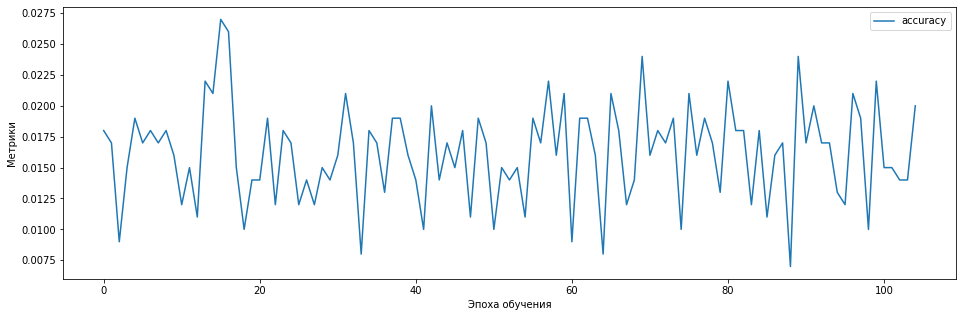

In [ ]:
#Отображаем график точности в процессе обучения
history_mae = []
for N in range(4):
  history_mae += history_list[N].history['accuracy']

plt.figure(figsize=(16,5))
plt.plot(history_mae, 
         label='accuracy')
plt.xlabel('Эпоха обучения')
plt.ylabel('Метрики')
plt.legend()
plt.show()

**Посмотрим предикт**

In [ ]:
# model = load_model('base-model-CNN.h5')
img = cv.imread('Voltmeter-Blank.jpg')
L, angle_0, angle_1 = u.gauge_needle_preparing(img)

N = 10
# fig, axs = plt.subplots(1, N, figsize=(18, 5))
for i in range(N):
  curr_img, curr_r = u.get_random_measurement(img, L, angle_0, angle_1)
  # подготовим изображение для отправки в модель
  img_to_pred = np.array(curr_img)
  # img_to_pred = cv.resize(img_to_pred, (224, 224), cv.INTER_LINEAR)
  img_to_pred = img_to_pred / 255. 
  img_to_pred = np.expand_dims(img_to_pred, axis = 0)
  pred = np.argmax(model.predict(img_to_pred)[0])
  print("Значение: {:.2f}, предикт {:.2f}".format(curr_r, np.argmax(pred[0]))
  


Значение: 0.77, предикт -3.38
Значение: 0.53, предикт -3.62
Значение: 0.64, предикт -1.64
Значение: 0.45, предикт -1.08
Значение: 0.46, предикт -0.86
Значение: 0.18, предикт -2.76
Значение: 0.74, предикт -3.19
Значение: 0.48, предикт -4.59
Значение: 0.54, предикт -4.48
Значение: 0.85, предикт -5.20


In [ ]:
# 
img = cv.imread('Voltmeter-Blank.jpg')
L, angle_0, angle_1 = u.gauge_needle_preparing(img)

N = 5
fig, axs = plt.subplots(2, N, figsize=(18, 5))
for i in range(N):
  curr_img, curr_r = u.get_random_measurement(img.copy(), L, angle_0, angle_1)
  angle_r = angle_0 + curr_r * (angle_1 - angle_0)

  # получаем предикт
  res_img, res_r = u.get_pred(feat_extractor, feat_np, angles, curr_img.copy(), L, angle_0, angle_1)
  
  # пересчитаем радианы в вольты
  curr_V = int(300 * curr_r)
  res_V = int(300 * res_r)

  axs[0,i].imshow(curr_img)
  axs[0,i].set_title(curr_V)
  axs[1,i].imshow(res_img)
  axs[1,i].set_title(res_V)

plt.show() 

True